In [ ]:
!gdown 1vRu3Pj2zYM_NL8xOheerI7wMgmAokdGv # grab latest merged file

Downloading...
From: https://drive.google.com/uc?id=1vRu3Pj2zYM_NL8xOheerI7wMgmAokdGv
To: /content/MAIN_ANNOTATIONS_MERGED.tsv
100% 893k/893k [00:00<00:00, 28.0MB/s]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

def plot_provider_reporting_quality(provider_name, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(16, 4), show_time_gaps=False, show_values=False, show_colorbar=True):
    """
    Generate a reporting quality heatmap for a single provider.

    Parameters:
    -----------
    provider_name : str
        Name of the provider to plot (e.g., 'openAi', 'meta', 'google', 'anthropic', 'mistral')
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # --- Font Setup ---
    # Download and register Times New Roman (regular, bold, and italic)
    font_files_to_download = {
        'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
        'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
        'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
    }

    # Create a directory for fonts if it doesn't exist
    font_dir = '/content/fonts'
    os.makedirs(font_dir, exist_ok=True)

    for fname, url in font_files_to_download.items():
        font_path = os.path.join(font_dir, fname)
        if not os.path.exists(font_path):
            subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

    # Register fonts with matplotlib
    for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
        fm.fontManager.addfont(font_path)

    # --- Matplotlib Style Configuration ---
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "font.size": 11,
        "axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 10,
        "ytick.labelsize": 11, "legend.fontsize": 16,
        "axes.spines.top": False, "axes.spines.left": False,
        "axes.spines.right": False, "axes.spines.bottom": False,
        "axes.titlepad": 6, "font.family": "Times New Roman",
        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",
    })

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping
    category_mapping = {
        1: "Bias & Harm", 2: "Sens. Content", 3: "Performance",
        4: "Env. & Emiss.", 5: "Privacy", 6: "Finan. Cost",
        7: "Mod. Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Forest green colormap
    colors_green = ['#F7FCF0', '#E8F6E3', '#BDE5B8', '#7BC77D', '#2E8B57', '#0B4D2C']
    cmap = LinearSegmentedColormap.from_list('forest_green_gradient', colors_green, N=256)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    all_categories = list(category_mapping.values())

    # Filter data for the specified provider
    curr_df = df[df.provider == provider_name].copy()

    if curr_df.empty:
        ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{provider_name}', fontsize=16, fontweight='bold', pad=25)
        return fig, ax

    # Get unique models sorted by release date
    models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

    model_names = []
    model_labels = []
    model_dates = []

    for _, row in models_info.iterrows():
        model_names.append(row['name'])
        formatted_name = row['name'].capitalize()
        model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
        model_dates.append(row['timestamp'])

    # Calculate positions - use simple integer positions for alignment
    num_models = len(model_names)
    model_positions = np.arange(num_models)

    # Create complete combinations for all categories and models
    complete_df = pd.DataFrame([
        {'name': model, 'category': category}
        for model in model_names
        for category in all_categories
    ])

    # Merge with actual data and fill missing scores with 0
    merged_df = complete_df.merge(
        curr_df[['name', 'category', 'score']],
        on=['name', 'category'],
        how='left'
    ).fillna({'score': 0})

    # Create pivot table
    heatmap_data = merged_df.pivot_table(
        index='category', columns='name', values='score', aggfunc='mean'
    ).reindex(index=all_categories, columns=model_names).fillna(0)

    # Create heatmap using rectangles - cells are 1x1 units
    for i, category in enumerate(all_categories):
        for j, model in enumerate(model_names):
            score = heatmap_data.loc[category, model]
            color = cmap(score / 3.0)

            rect = plt.Rectangle((model_positions[j] - 0.45, i - 0.45),
                               0.9, 0.9,
                               facecolor=color, edgecolor='white', linewidth=1)
            ax.add_patch(rect)

            if show_values:
                text_color = 'white' if score > 1.5 else 'black'
                ax.text(model_positions[j], i, f'{score:.1f}',
                       ha='center', va='center', fontsize=9,
                       fontweight='bold', color=text_color)

    # --- Axis and Label Formatting ---
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_labels, rotation=90, ha='center', fontsize=12, fontweight='bold')

    ax.set_yticks(range(len(all_categories)))
    wrapped_labels = [textwrap.fill(label, width=15) for label in all_categories]
    ax.set_yticklabels(wrapped_labels, fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', which='both', length=0, pad=5)
    ax.tick_params(axis='y', which='both', length=0, pad=5)

    # Add time gap indicators if requested
    if show_time_gaps and len(model_dates) > 1:
        for i in range(1, len(model_dates)):
            gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44
            if gap_months > 6:
                gap_x = (model_positions[i-1] + model_positions[i]) / 2
                ax.axvline(x=gap_x, color='#bdc3c7', linewidth=1.5, linestyle='solid')

    # Set axis limits - tight to the data
    ax.set_xlim(-0.6, num_models - 0.4)
    ax.set_ylim(-0.6, len(all_categories) - 0.4)
    ax.grid(False)

    # Add colorbar if requested
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20, pad=0.03)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        cbar.outline.set_visible(False)

    # Titles
    ax.set_title(f'{provider_name.capitalize()}',
                 fontsize=20, fontweight='bold', pad=25)

    plt.tight_layout()

    return fig, ax

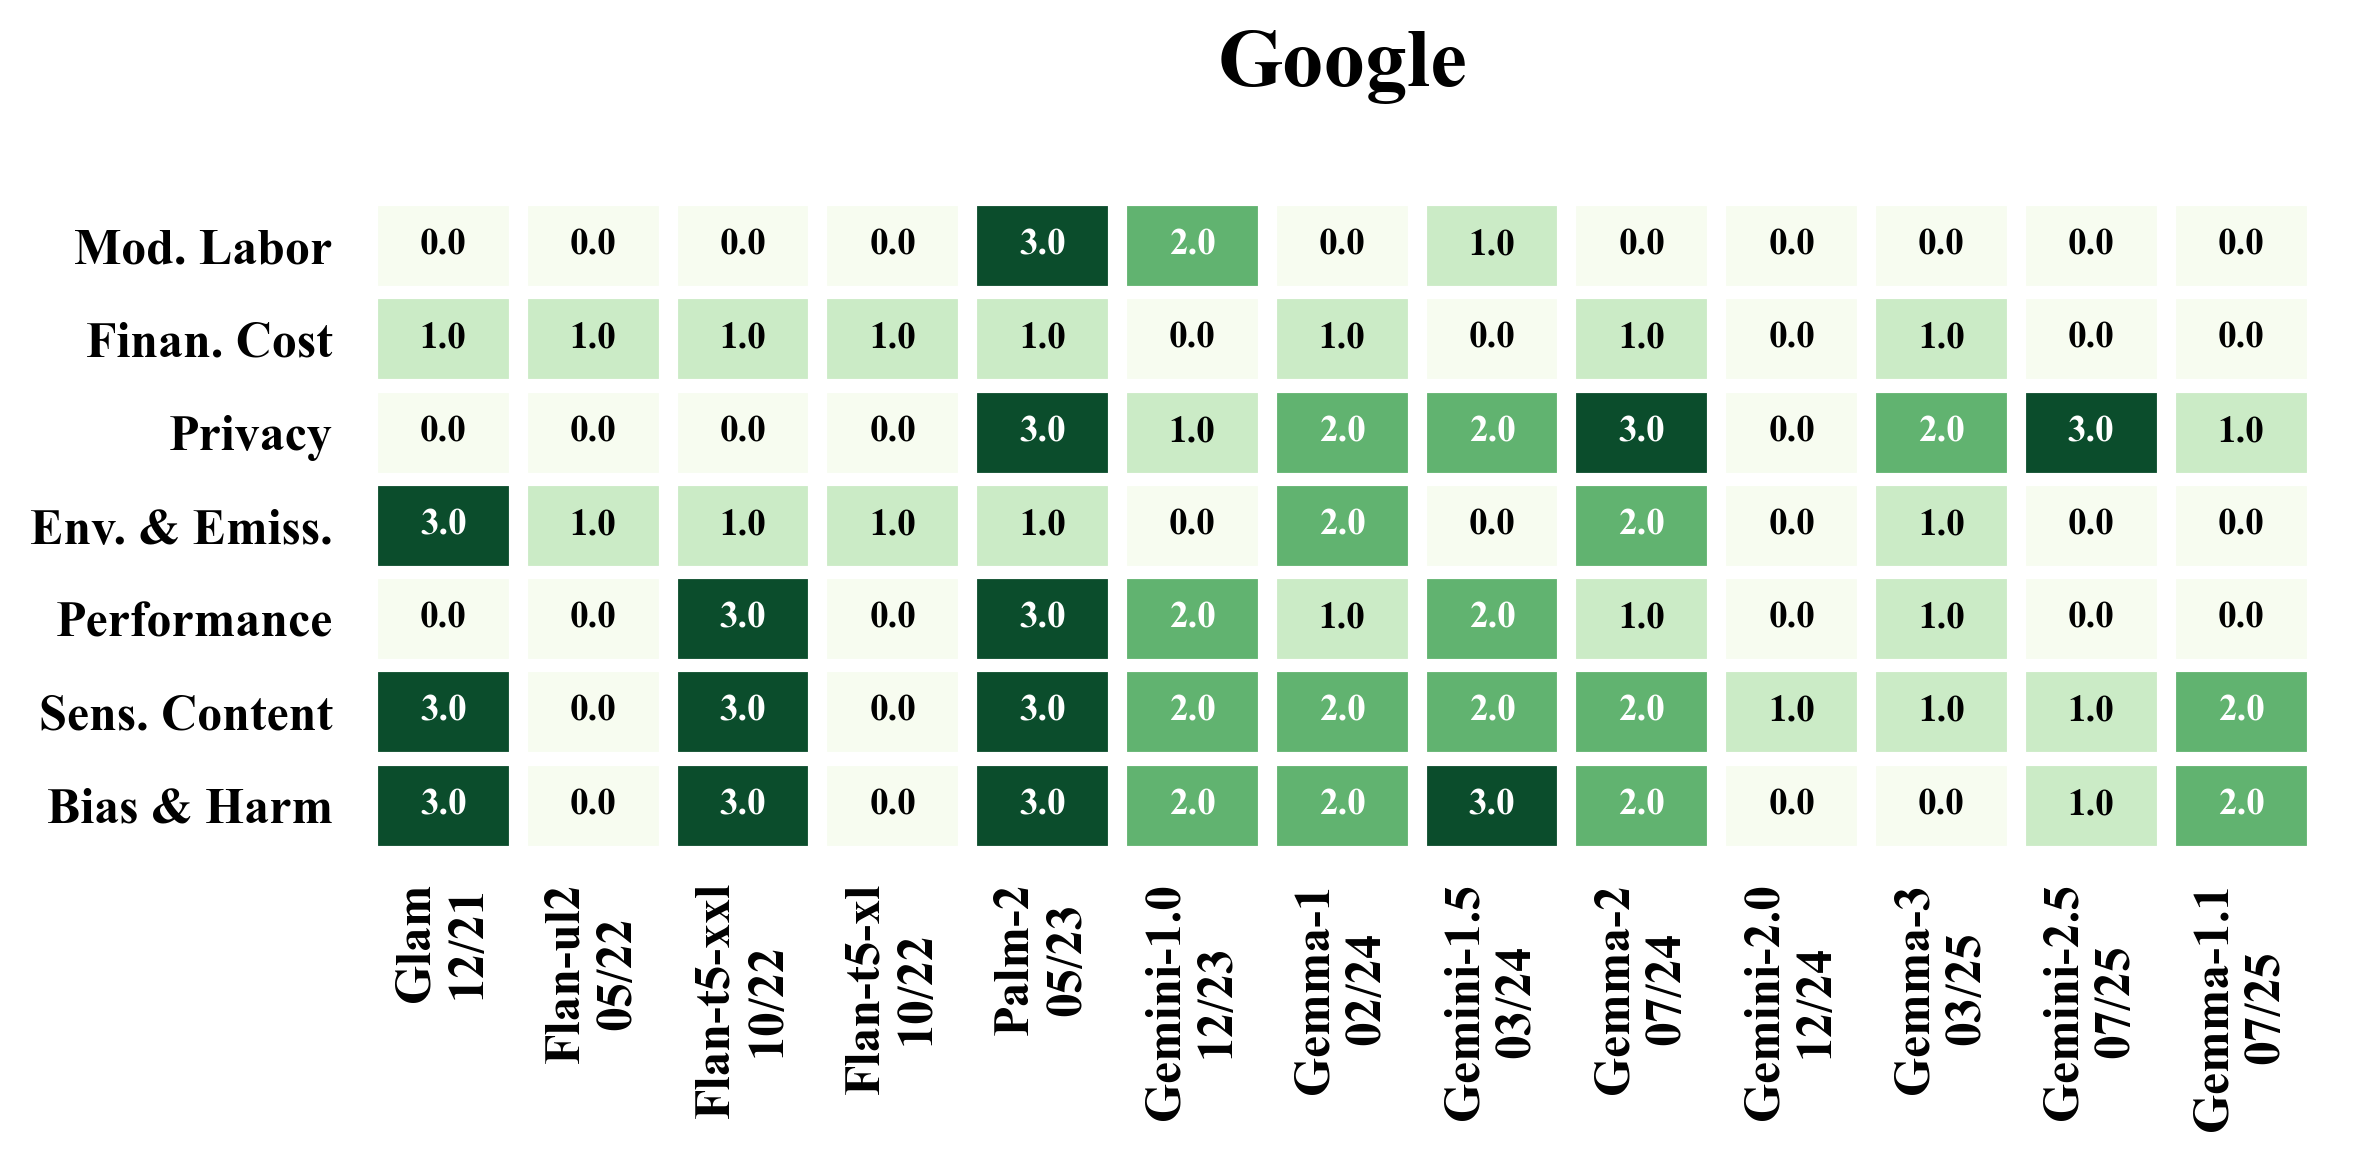

In [ ]:
fig, ax = plot_provider_reporting_quality('Google', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('google_1p_overtime_adjusted.pdf')
plt.show()

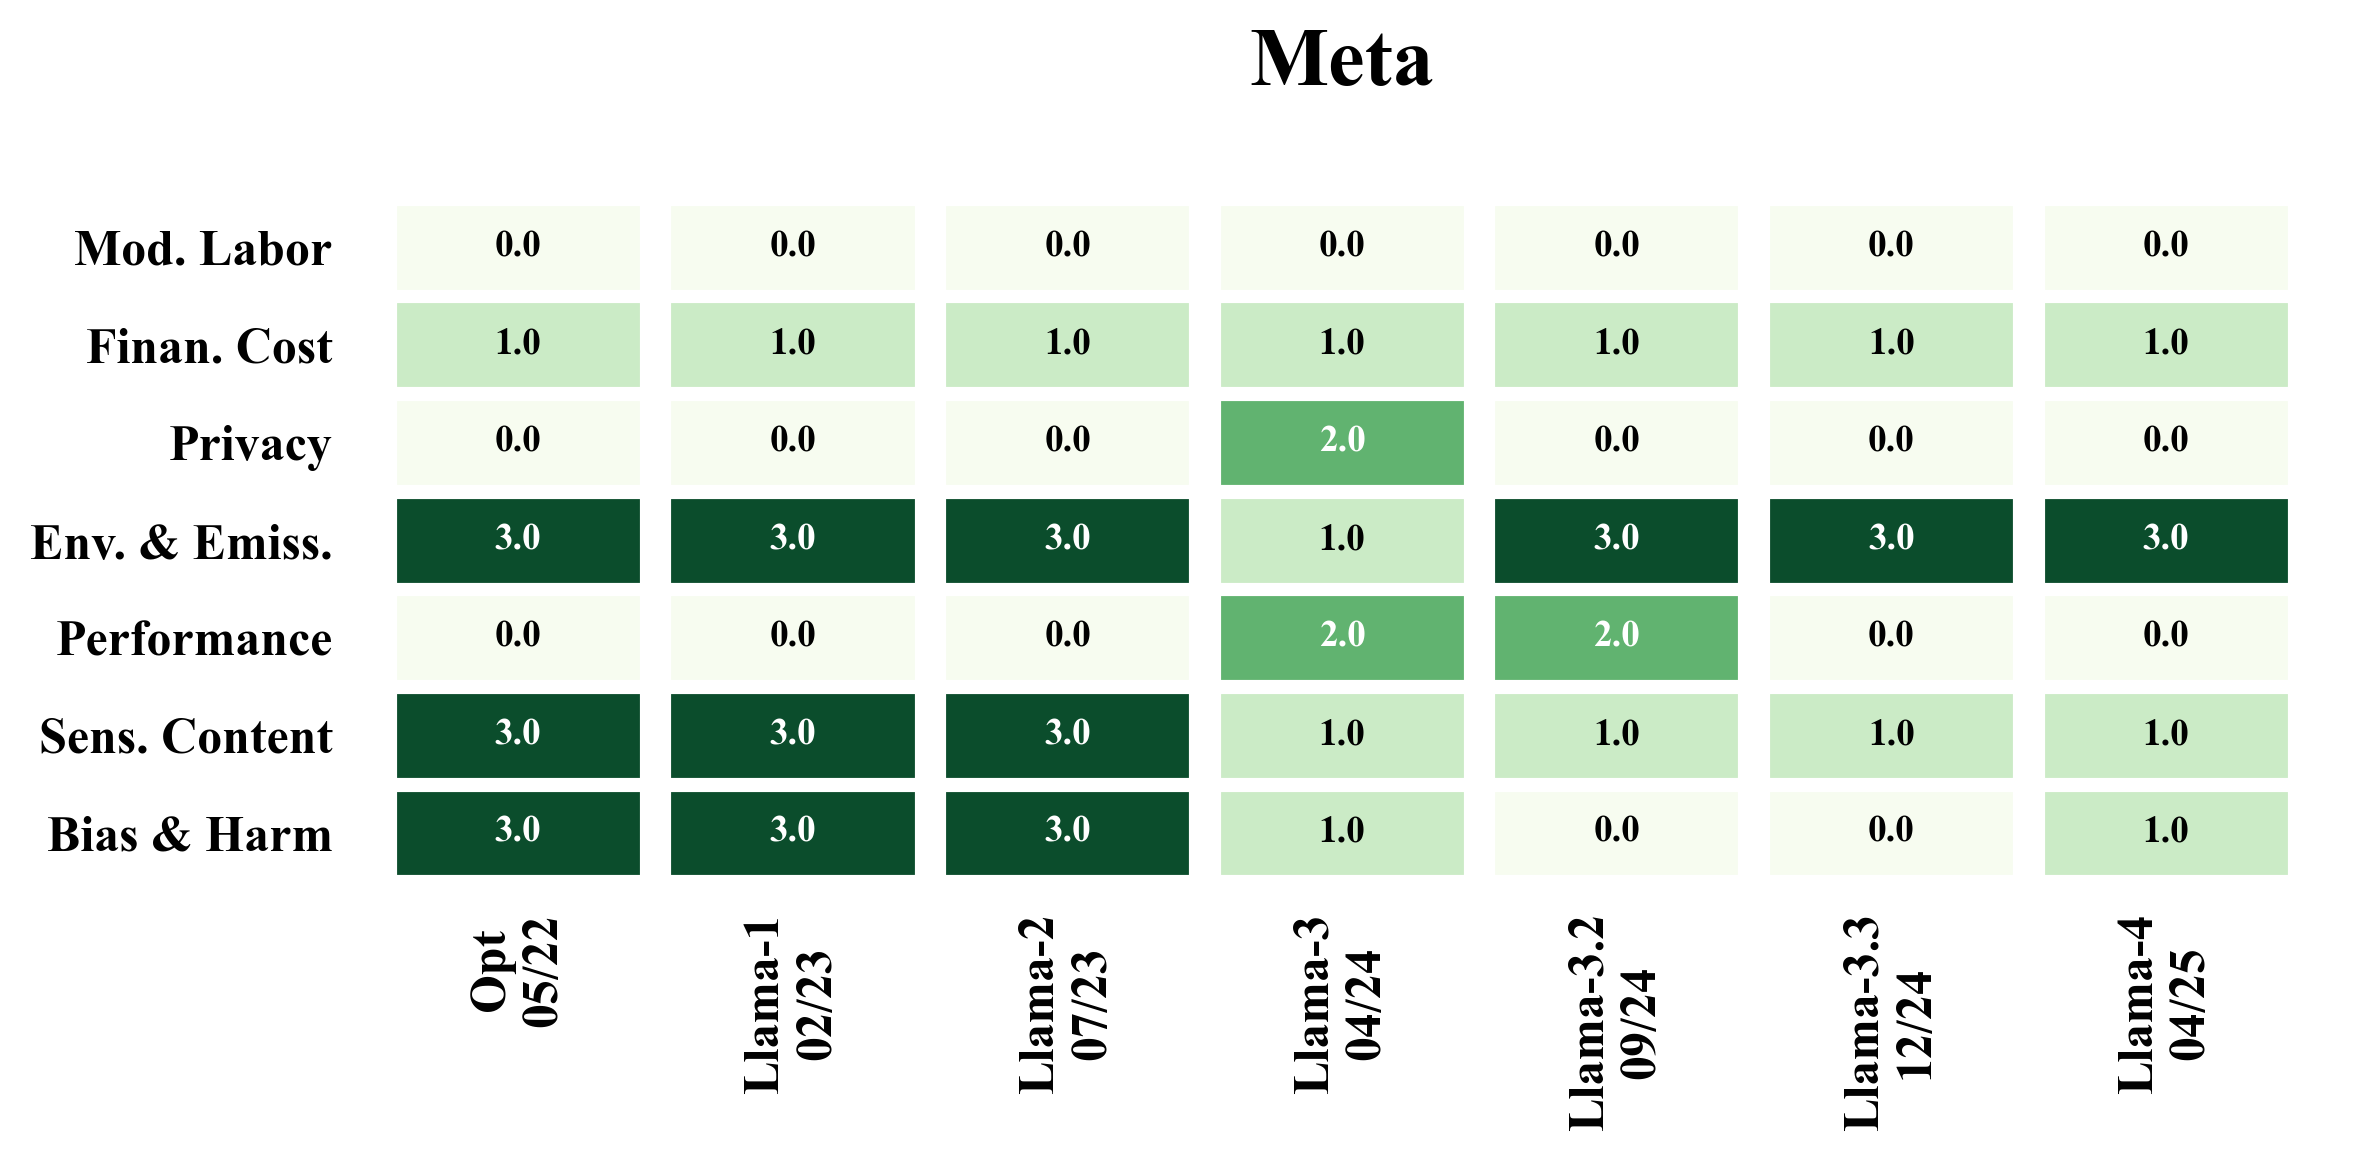

In [ ]:
fig, ax = plot_provider_reporting_quality('Meta', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('meta_1p_overtime_adjusted.pdf')
plt.show()

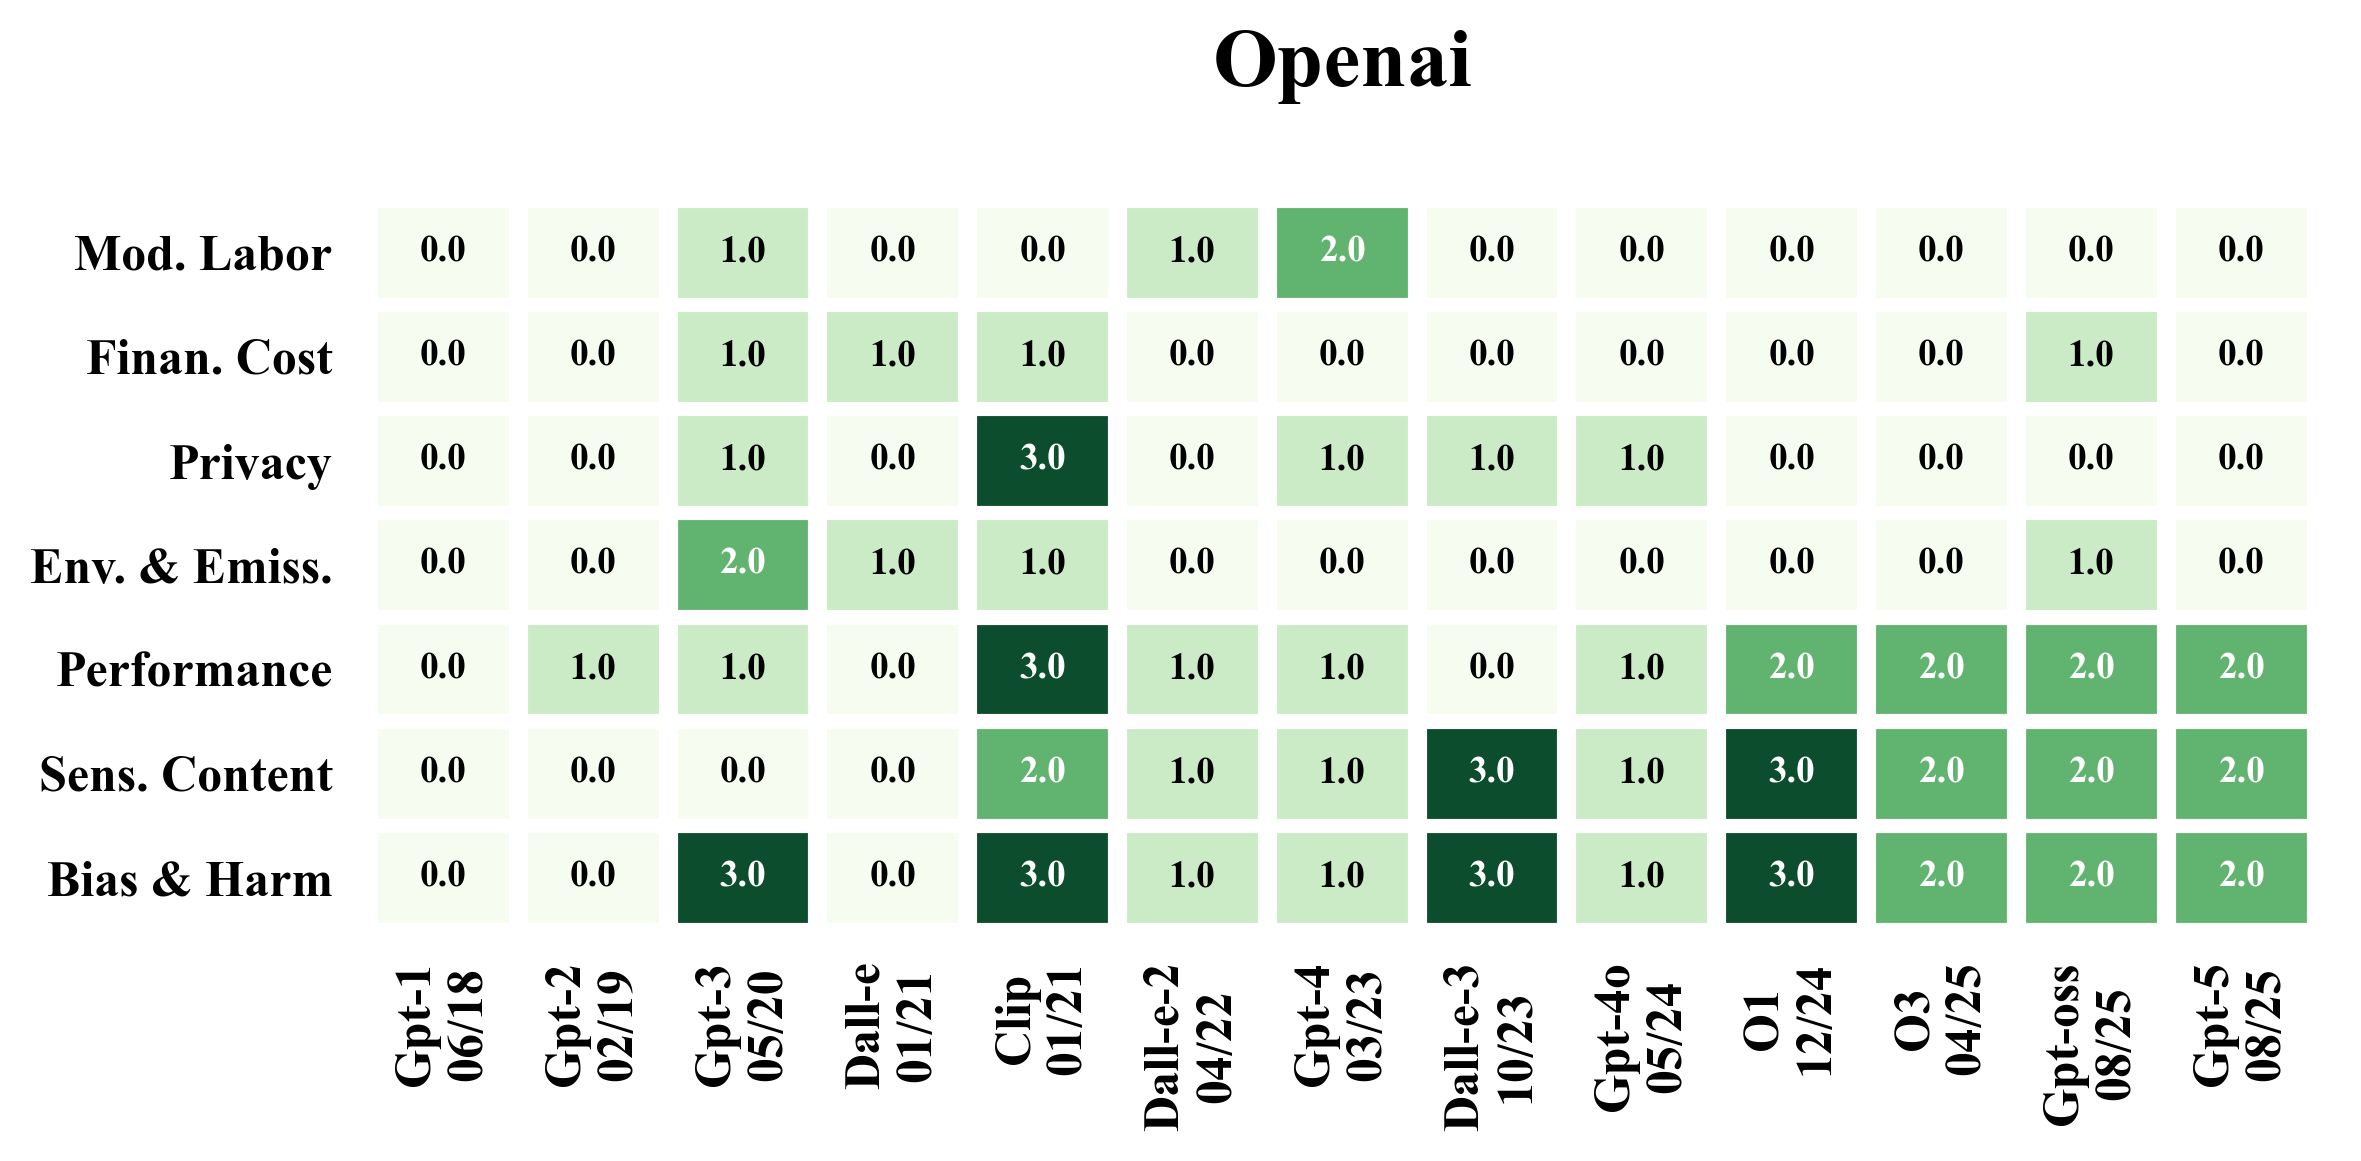

In [ ]:
fig, ax = plot_provider_reporting_quality('OpenAI', figsize=(8, 4), show_values=True, show_colorbar=False)
plt.savefig('openai_1p_overtime_adjusted.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.font_manager as fm
import subprocess
import os
import textwrap

def plot_dual_provider_reporting_quality(provider_names, df_path="MAIN_ANNOTATIONS_MERGED.tsv", figsize=(16, 4), show_time_gaps=False, show_values=False, show_colorbar=True, width_ratios='auto'):
    """
    Generate reporting quality heatmaps for two providers side by side with shared y-axis.

    Parameters:
    -----------
    provider_names : list of str
        Names of two providers to plot (e.g., ['openAi', 'anthropic'])
    df_path : str
        Path to the TSV file containing the data
    figsize : tuple
        Figure size as (width, height)
    show_time_gaps : bool
        Whether to show dotted lines indicating time gaps > 6 months between models
    show_values : bool
        Whether to display the score values inside each cell
    show_colorbar : bool
        Whether to display the colorbar legend
    width_ratios : str or list
        Either 'auto' to automatically calculate based on number of models,
        or a list of two numbers representing the width ratio (e.g., [2, 1])

    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """

    if len(provider_names) != 2:
        raise ValueError("Exactly 2 provider names must be provided")

    # --- Font Setup ---
    font_files_to_download = {
        'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
        'TimesNewRomanBold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
        'TimesNewRomanItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf'
    }

    font_dir = '/content/fonts'
    os.makedirs(font_dir, exist_ok=True)

    for fname, url in font_files_to_download.items():
        font_path = os.path.join(font_dir, fname)
        if not os.path.exists(font_path):
            subprocess.run(['curl', '-L', url, '-o', font_path], capture_output=True, check=True)

    for font_path in fm.findSystemFonts(fontpaths=[font_dir], fontext='ttf'):
        fm.fontManager.addfont(font_path)

    # --- Matplotlib Style Configuration ---
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300, "font.size": 11,
        "axes.titlesize": 20, "axes.labelsize": 15, "xtick.labelsize": 10,
        "ytick.labelsize": 11, "legend.fontsize": 16,
        "axes.spines.top": False, "axes.spines.left": False,
        "axes.spines.right": False, "axes.spines.bottom": False,
        "axes.titlepad": 6, "font.family": "Times New Roman",
        "mathtext.fontset": "custom",
        "mathtext.rm": "Times New Roman",
        "mathtext.it": "Times New Roman:italic",
        "mathtext.bf": "Times New Roman:bold",
    })

    # Load and prepare data
    df = pd.read_csv(df_path, sep="\t")

    # Category mapping
    category_mapping = {
        1: "Bias & Harm", 2: "Sens. Content", 3: "Performance",
        4: "Env. & Emiss.", 5: "Privacy", 6: "Finan. Cost",
        7: "Mod. Labor"
    }
    df['category'] = df['category'].map(category_mapping)

    # Filter for model releases only
    df = df[df.is_model_release == True].copy()

    # Parse timestamps from metadata
    df['timestamp'] = pd.to_datetime(
        df['metadata'].apply(lambda x: ast.literal_eval(x)['release_date'])
    )

    # Sort by release date
    df = df.sort_values('timestamp')

    # Forest green colormap
    colors_green = ['#F7FCF0', '#E8F6E3', '#BDE5B8', '#7BC77D', '#2E8B57', '#0B4D2C']
    cmap = LinearSegmentedColormap.from_list('forest_green_gradient', colors_green, N=256)

    all_categories = list(category_mapping.values())

    # First, count models for each provider to determine width ratios
    model_counts = []
    for provider_name in provider_names:
        curr_df = df[df.provider == provider_name].copy()
        if not curr_df.empty:
            num_models = curr_df['name'].nunique()
        else:
            num_models = 1  # Default if no data
        model_counts.append(num_models)

    # Calculate width ratios
    if width_ratios == 'auto':
        width_ratios = model_counts

    # Create figure with two subplots sharing y-axis with custom width ratios
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True,
                             gridspec_kw={'width_ratios': width_ratios})
    fig.patch.set_facecolor('white')

    # Process each provider
    for ax_idx, provider_name in enumerate(provider_names):
        ax = axes[ax_idx]
        ax.set_facecolor('white')

        # Filter data for the specified provider
        curr_df = df[df.provider == provider_name].copy()

        if curr_df.empty:
            ax.text(0.5, 0.5, f'No data found for provider: {provider_name}',
                    ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{provider_name}', fontsize=16, fontweight='bold', pad=25)
            continue

        # Get unique models sorted by release date
        models_info = curr_df[['name', 'timestamp']].drop_duplicates().sort_values('timestamp')

        model_names = []
        model_labels = []
        model_dates = []

        for _, row in models_info.iterrows():
            model_names.append(row['name'])
            formatted_name = row['name'].capitalize()
            model_labels.append(f"{formatted_name}\n{row['timestamp'].strftime('%m/%y')}")
            model_dates.append(row['timestamp'])

        # Calculate positions
        num_models = len(model_names)
        model_positions = np.arange(num_models)

        # Create complete combinations for all categories and models
        complete_df = pd.DataFrame([
            {'name': model, 'category': category}
            for model in model_names
            for category in all_categories
        ])

        # Merge with actual data and fill missing scores with 0
        merged_df = complete_df.merge(
            curr_df[['name', 'category', 'score']],
            on=['name', 'category'],
            how='left'
        ).fillna({'score': 0})

        # Create pivot table
        heatmap_data = merged_df.pivot_table(
            index='category', columns='name', values='score', aggfunc='mean'
        ).reindex(index=all_categories, columns=model_names).fillna(0)

        # Create heatmap using rectangles
        for i, category in enumerate(all_categories):
            for j, model in enumerate(model_names):
                score = heatmap_data.loc[category, model]
                color = cmap(score / 3.0)

                rect = plt.Rectangle((model_positions[j] - 0.45, i - 0.45),
                                   0.9, 0.9,
                                   facecolor=color, edgecolor='white', linewidth=1)
                ax.add_patch(rect)

                if show_values:
                    text_color = 'white' if score > 1.5 else 'black'
                    ax.text(model_positions[j], i, f'{score:.1f}',
                           ha='center', va='center', fontsize=11,
                           fontweight='bold', color=text_color)

        # --- Axis and Label Formatting ---
        ax.set_xticks(model_positions)
        ax.set_xticklabels(model_labels, rotation=90, ha='center', fontsize=13, fontweight='bold')

        # Only show y-axis labels on the left subplot
        if ax_idx == 0:
            ax.set_yticks(range(len(all_categories)))
            wrapped_labels = [textwrap.fill(label, width=15) for label in all_categories]
            ax.set_yticklabels(wrapped_labels, fontsize=13, fontweight='bold')

        ax.tick_params(axis='x', which='both', length=0, pad=5)
        ax.tick_params(axis='y', which='both', length=0, pad=5)

        # Add time gap indicators if requested
        if show_time_gaps and len(model_dates) > 1:
            for i in range(1, len(model_dates)):
                gap_months = (model_dates[i] - model_dates[i-1]).days / 30.44
                if gap_months > 6:
                    gap_x = (model_positions[i-1] + model_positions[i]) / 2
                    ax.axvline(x=gap_x, color='#bdc3c7', linewidth=1.5, linestyle=':')

        # Set axis limits
        ax.set_xlim(-0.6, num_models - 0.4)
        ax.set_ylim(-0.6, len(all_categories) - 0.4)
        ax.grid(False)

        # Titles
        ax.set_title(f'{provider_name.capitalize()}',
                     fontsize=20, fontweight='bold', pad=25)

        # Add vertical separator line on the right edge of the first subplot
        if ax_idx == 0:
            ax.axvline(x=num_models - 0.4, color='#000000', linewidth=3.0,
                      linestyle='solid', alpha=0.6, zorder=10)

    # Add single colorbar on the right side if requested
    if show_colorbar:
        norm = Normalize(vmin=0, vmax=3)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig.colorbar(sm, ax=axes, shrink=0.8, aspect=20, pad=0.03)
        cbar.set_label('Reporting Quality Score', rotation=270, labelpad=20, fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        cbar.outline.set_visible(False)

    plt.tight_layout()

    return fig, axes


# Usage example:
# fig, axes = plot_dual_provider_reporting_quality(['google', 'meta'], df_path="MAIN_ANNOTATIONS_MERGED.tsv")
# This will automatically allocate more space to Google since it has more models
#
# Or specify custom width ratios:
# fig, axes = plot_dual_provider_reporting_quality(['google', 'meta'], width_ratios=[3, 1])
# plt.show()

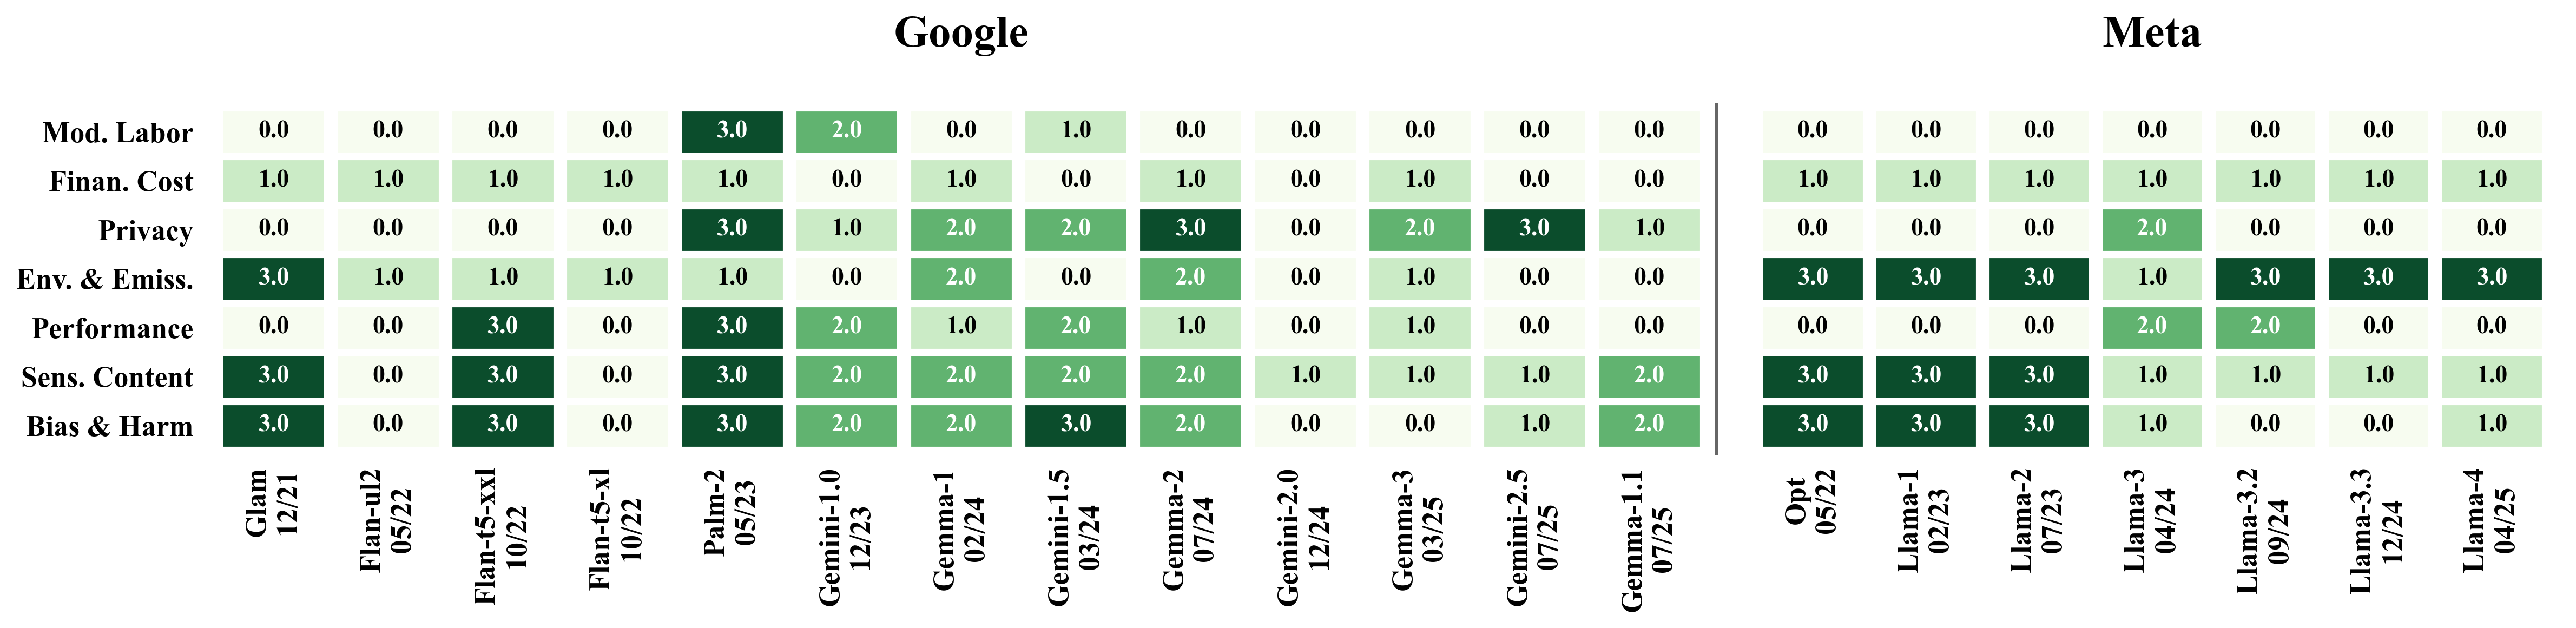

In [ ]:
fig, axes = plot_dual_provider_reporting_quality(['Google', 'Meta'], df_path="MAIN_ANNOTATIONS_MERGED.tsv",
                                                 show_colorbar=False, show_values=True)
plt.savefig('google_meta_1p_overtime_adjusted.pdf')
plt.show()